# Random Forest with SMOTE and Grid Search CV

* SMOTE - minority
* Include High Cardinality Features
* Recall and Accuracy Scores

# Imports and Constants

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
import joblib
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score


In [2]:
RANDOM_SEED = 8
DATA_PATH = '../data/'
MODEL_PATH = '../models/'
SAVE_MODEL = True
MODEL_FILE_NAME = 'rand_forest_cv3.sav'

## Read in Data

In [3]:
df = pd.read_csv(DATA_PATH+'clean_water_well_data.csv')
df.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,subvillage,region,lga,...,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group
0,2011-03-14,roman,1390.000000,roman,34.938093,-9.856322,0,Mnyusi B,Iringa,Ludewa,...,False,1999,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional
1,2013-03-06,grumeti,1399.000000,grumeti,34.698766,-2.147466,0,Nyamara,Mara,Serengeti,...,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional
2,2013-02-25,lottery club,686.000000,world vision,37.460664,-3.821329,0,Majengo,Manyara,Simanjiro,...,True,2009,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional
3,2013-01-28,unicef,263.000000,unicef,38.486161,-11.155298,0,Mahakamani,Mtwara,Nanyumbu,...,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional
4,2011-07-13,action in a,1018.821805,artisan,31.130847,-1.825359,0,Kyanyamisa,Kagera,Karagwe,...,True,2000,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional


## Split data into features and labels

In [4]:
y = df.status_group
X = df.drop('status_group', axis=1)

## Train / Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

## Define Pipeline

In [6]:
# high cardinality features
high_card = ['funder', 'installer', 'lga', 'subvillage', 'ward']

# not useful features
not_useful = ['date_recorded', 'longitude', 'latitude']

unwanted = high_card + not_useful

In [7]:
cols_to_scale = ['gps_height', 'num_private', 'population', 'construction_year']

In [8]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [9]:
# categorical_features = list(X.select_dtypes(include=['bool', 'object']).columns)
categorical_features = ['region',
                         'public_meeting',
                         'permit',
                         'extraction_type',
                         'management',
                         'payment',
                         'water_quality',
                         'quantity',
                         'source',
                         'waterpoint_type'] + high_card
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [10]:
preprocessor = ColumnTransformer(remainder='drop',
                                 transformers=[('num', numeric_transformer, cols_to_scale),
                                               ('cat', categorical_transformer, categorical_features)])

In [11]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                         ('sampling', SMOTE(random_state=RANDOM_SEED, n_jobs=-1, sampling_strategy='minority')),
                        ('classifier', RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1))
                        ])

## Encode Labels

In [12]:
le = LabelEncoder()

### Training Features

In [13]:
y_train_ready = le.fit_transform(y_train)

### Test Features

In [14]:
y_test_ready = le.transform(y_test)

## Random Forest Classifier Model

### Fit The Model

In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
num_features = int(np.sqrt(20000))
max_features = [int(x) for x in np.linspace(start=num_features-5, stop=num_features+5, num=10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 45, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6]


# Create the random grid
parameters = [{'classifier__n_estimators': n_estimators,
              'classifier__max_features': max_features,
              'classifier__max_depth': max_depth,
              'classifier__min_samples_split': min_samples_split,
              'classifier__min_samples_leaf': min_samples_leaf}]

scorers = {
    'recall_score': make_scorer(recall_score, average='weighted')
     , 'accuracy_score': make_scorer(accuracy_score)
}

gridsearch = RandomizedSearchCV(pipe, parameters, cv=5, random_state=RANDOM_SEED, 
                                scoring=scorers, n_jobs=-1, refit='recall_score',
                               n_iter=5)
clf = gridsearch.fit(X_train, y_train_ready)

### Get Model Predictions

In [16]:
y_hat_train = clf.predict(X_train)

In [17]:
y_hat_test = clf.predict(X_test)

### Classification Reports

In [18]:
print(classification_report(y_train_ready, y_hat_train, target_names=le.classes_))

                         precision    recall  f1-score   support

             functional       0.75      0.81      0.78     24140
functional needs repair       0.28      0.72      0.40      3210
         non functional       0.91      0.54      0.67     17069

               accuracy                           0.70     44419
              macro avg       0.65      0.69      0.62     44419
           weighted avg       0.78      0.70      0.71     44419



In [19]:
print(classification_report(y_test_ready, y_hat_test, target_names=le.classes_))

                         precision    recall  f1-score   support

             functional       0.73      0.79      0.76      8031
functional needs repair       0.25      0.65      0.36      1084
         non functional       0.89      0.52      0.66      5692

               accuracy                           0.68     14807
              macro avg       0.63      0.66      0.59     14807
           weighted avg       0.76      0.68      0.69     14807



### Confusion Matrices

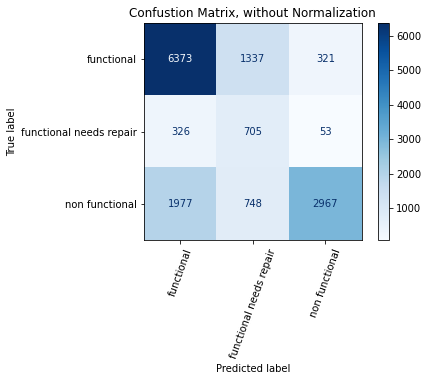

In [20]:
matrix = plot_confusion_matrix(clf, X_test, y_test_ready,
                            display_labels=le.classes_,
                            cmap=plt.cm.Blues,
                            xticks_rotation=70)
matrix.ax_.set_title('Confustion Matrix, without Normalization')

plt.show()

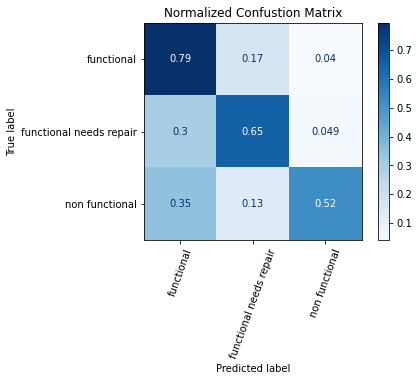

In [21]:
matrix_norm = plot_confusion_matrix(clf, X_test, y_test_ready,
                                   display_labels=le.classes_,
                                   cmap=plt.cm.Blues,
                                   normalize='true',
                                   xticks_rotation=70)
matrix_norm.ax_.set_title('Normalized Confustion Matrix')

plt.show()

### Compute Multiclass AUC Score

In [35]:
# convert labels from shape n, to n,3
lb = LabelBinarizer()
lb.fit(y_test_ready)
y_test_multi = lb.transform(y_test_ready)
y_hat_test_multi = clf.predict_proba(X_test)
# y_hat_test_multi = lb.transform(clf.predict(X_test))

In [36]:
roc_auc_score(y_test_ready, y_hat_test_multi, multi_class='ovr')

0.8375900323388823

### Multiclass ROC Curves

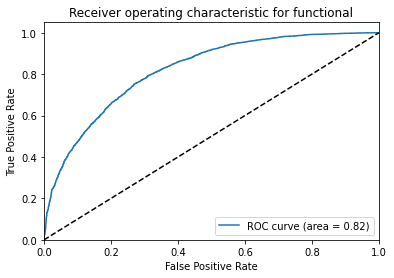

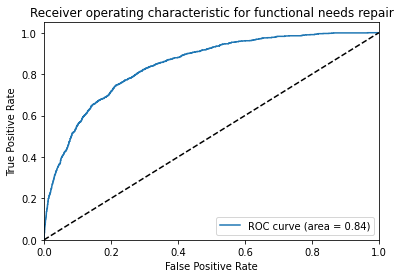

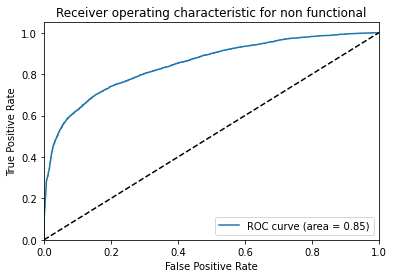

In [37]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_multi[:, i], y_hat_test_multi[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i, class_ in enumerate(le.classes_):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic for {class_}')
    plt.legend(loc="lower right")
    plt.show()

## Save Model

In [25]:
if SAVE_MODEL:
    joblib.dump(clf, MODEL_PATH+MODEL_FILE_NAME)

## Summary of Results

In [26]:
feature_importances = clf.best_estimator_[2].feature_importances_

In [27]:
cats = clf.best_estimator_[0].transformers_[1][1]['onehot'].get_feature_names()

In [28]:
cols = cols_to_scale + list(cats)

In [29]:
feature_importances_df = pd.DataFrame(feature_importances, index=cols, columns=['importance']).sort_values('importance', ascending=False)

In [30]:
feature_importances_df.head(10)

,importance
x7_dry,0.061407
x9_other,0.031396
x3_other,0.030505
x7_enough,0.027137
construction_year,0.021261
x3_gravity,0.018827
x5_never pay,0.018000
x7_insufficient,0.016740
x12_Bariadi,0.016649
gps_height,0.015090


In [31]:
X_train.columns

Index(['date_recorded', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'num_private', 'subvillage', 'region', 'lga', 'ward',
       'population', 'public_meeting', 'permit', 'construction_year',
       'extraction_type', 'management', 'payment', 'water_quality', 'quantity',
       'source', 'waterpoint_type'],
      dtype='object')

In [32]:
clf.cv_results_

{'mean_fit_time': array([424.1243999 , 221.74707994, 143.53949933, 246.19199457,
         78.96794844]),
 'std_fit_time': array([ 8.14900846, 19.30465703, 21.25487836, 26.50505407, 25.46286068]),
 'mean_score_time': array([8.35156784, 6.18499932, 5.13263764, 9.35326672, 2.2492857 ]),
 'std_score_time': array([1.09502425, 1.03673921, 0.74456331, 3.50981915, 0.76383622]),
 'param_classifier__n_estimators': masked_array(data=[1600, 1000, 800, 2000, 400],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__min_samples_split': masked_array(data=[5, 5, 10, 2, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__min_samples_leaf': masked_array(data=[4, 2, 4, 6, 2],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__max_features': masked_array(data=[136, 141, 138, 

In [33]:
clf.best_params_

{'classifier__n_estimators': 1600,
 'classifier__min_samples_split': 5,
 'classifier__min_samples_leaf': 4,
 'classifier__max_features': 136,
 'classifier__max_depth': 45}

In [34]:
len(feature_importances)

22219